# 1. Using a pre-trained convnet

## 1.1 Feature extraction

### 1.1.1 Instantiating the VGG16 convolutional base

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


### 1.1.2 Displaying a summary of the convolutional base

In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### 1.1.3 Extracting features using the pre-trained convolutional base

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape= (sample_count, 4, 4, 512))
    labels = np.zeros(shape= (sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop
            # we must 'break' after every image has been seen once.
            break
    return features, labels

In [4]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, 
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s - loss: 0.6800 - acc: 0.6060 - val_loss: 0.5371 - val_acc: 0.7800
Epoch 2/30
2000/2000 [==============================] - 0s - loss: 0.5233 - acc: 0.7420 - val_loss: 0.4456 - val_acc: 0.8320
Epoch 3/30
2000/2000 [==============================] - 0s - loss: 0.4467 - acc: 0.7935 - val_loss: 0.3978 - val_acc: 0.8480
Epoch 4/30
2000/2000 [==============================] - 0s - loss: 0.3933 - acc: 0.8310 - val_loss: 0.3597 - val_acc: 0.8680
Epoch 5/30
2000/2000 [==============================] - 0s - loss: 0.3646 - acc: 0.8400 - val_loss: 0.3377 - val_acc: 0.8740
Epoch 6/30
2000/2000 [==============================] - 0s - loss: 0.3463 - acc: 0.8600 - val_loss: 0.3221 - val_acc: 0.8780
Epoch 7/30
2000/2000 [==============================] - 0s - loss: 0.3159 - acc: 0.8730 - val_loss: 0.3087 - val_acc: 0.8830
Epoch 8/30
2000/2000 [==============================] - 0s - loss: 0.3022 - a

### 1.1.4 Plotting our results

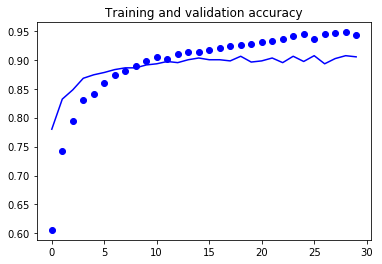

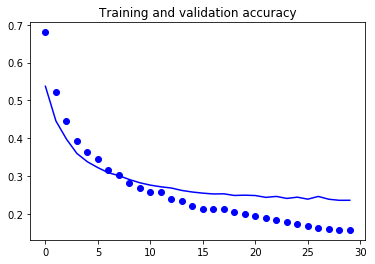

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation accuracy')

plt.show()

### 1.1.5 Adding a densely-connected classifier on top of the convolutional base

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### 1.1.6 Summary of the extended model

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('This is the number of trainable weights '
      'before freezing the conv base: ', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base:  30


In [11]:
conv_base.trainable = False

In [12]:
print('This is the number of trainable weights '
      'after freezing the conv base: ', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base:  4


### 1.1.7 Training the model end-to-end with a frozen convolutional base

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 62s - loss: 0.4482 - acc: 0.7885 - val_loss: 0.2514 - val_acc: 0.8930
Epoch 2/100
100/100 [==============================] - 60s - loss: 0.2790 - acc: 0.8845 - val_loss: 0.1670 - val_acc: 0.9210
Epoch 3/100
100/100 [==============================] - 60s - loss: 0.2394 - acc: 0.9010 - val_loss: 0.1487 - val_acc: 0.9370
Epoch 4/100
100/100 [==============================] - 60s - loss: 0.1883 - acc: 0.9235 - val_loss: 0.1926 - val_acc: 0.9270
Epoch 5/100
100/100 [==============================] - 60s - loss: 0.1580 - acc: 0.9360 - val_loss: 0.1658 - val_acc: 0.9390
Epoch 6/100
100/100 [==============================] - 60s - loss: 0.1525 - acc: 0.9340 - val_loss: 0.1039 - val_acc: 0.9530
Epoch 7/100
100/100 [==============================] - 60s - loss: 0.1419 - acc: 0.9350 - val_loss: 0.1139 - val_acc: 0.9520
Epoch 8/100
100/100 [====================

100/100 [==============================] - 60s - loss: 0.0213 - acc: 0.9930 - val_loss: 0.1182 - val_acc: 0.9730
Epoch 66/100
100/100 [==============================] - 60s - loss: 0.0170 - acc: 0.9955 - val_loss: 0.1329 - val_acc: 0.9680
Epoch 67/100
100/100 [==============================] - 60s - loss: 0.0113 - acc: 0.9965 - val_loss: 0.0926 - val_acc: 0.9780
Epoch 68/100
100/100 [==============================] - 60s - loss: 0.0171 - acc: 0.9920 - val_loss: 0.1387 - val_acc: 0.9720
Epoch 69/100
100/100 [==============================] - 60s - loss: 0.0175 - acc: 0.9945 - val_loss: 0.0937 - val_acc: 0.9800
Epoch 70/100
100/100 [==============================] - 60s - loss: 0.0154 - acc: 0.9960 - val_loss: 0.1122 - val_acc: 0.9750
Epoch 71/100
100/100 [==============================] - 60s - loss: 0.0090 - acc: 0.9975 - val_loss: 0.1270 - val_acc: 0.9760
Epoch 72/100
100/100 [==============================] - 60s - loss: 0.0188 - acc: 0.9955 - val_loss: 0.1384 - val_acc: 0.9780
Epoch

### 1.1.8 Plotting our results (2)

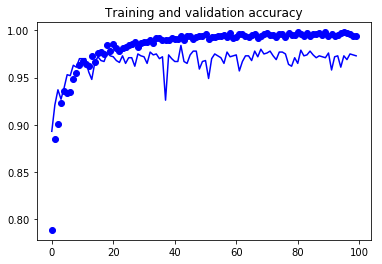

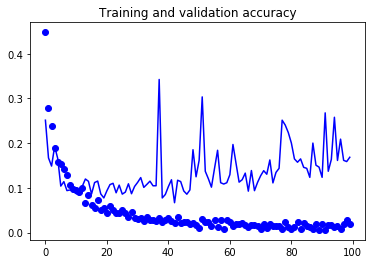

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation accuracy')

plt.show()

### 1.1.9 Displaying a summary of the convolutional base

In [15]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### 1.1.10 Freezing all alyers up to a specific one

In [16]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### 1.1.11 Fine-tuning our model

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 28s - loss: 0.2000 - acc: 0.9765 - val_loss: 0.2337 - val_acc: 0.9610
Epoch 2/100
100/100 [==============================] - 28s - loss: 0.1173 - acc: 0.9790 - val_loss: 0.1525 - val_acc: 0.9760
Epoch 3/100
100/100 [==============================] - 28s - loss: 0.0453 - acc: 0.9875 - val_loss: 0.2506 - val_acc: 0.9690
Epoch 4/100
100/100 [==============================] - 28s - loss: 0.0576 - acc: 0.9870 - val_loss: 0.1405 - val_acc: 0.9770
Epoch 5/100
100/100 [==============================] - 28s - loss: 0.0598 - acc: 0.9845 - val_loss: 0.2274 - val_acc: 0.9570
Epoch 6/100
100/100 [==============================] - 28s - loss: 0.0544 - acc: 0.9875 - val_loss: 0.1811 - val_acc: 0.9780
Epoch 7/100
100/100 [==============================] - 28s - loss: 0.0861 - acc: 0.9855 - val_loss: 0.2207 - val_acc: 0.9610
Epoch 8/100
100/100 [==============================] - 28s - loss: 0.0567 - acc: 0.9905 - val_loss: 0.1841 - val_acc: 0.9670


100/100 [==============================] - 28s - loss: 0.0466 - acc: 0.9935 - val_loss: 0.4171 - val_acc: 0.9650
Epoch 67/100
100/100 [==============================] - 28s - loss: 0.1014 - acc: 0.9925 - val_loss: 0.5611 - val_acc: 0.9630
Epoch 68/100
100/100 [==============================] - 28s - loss: 0.0895 - acc: 0.9915 - val_loss: 0.3515 - val_acc: 0.9700
Epoch 69/100
100/100 [==============================] - 28s - loss: 0.2129 - acc: 0.9835 - val_loss: 0.3911 - val_acc: 0.9710
Epoch 70/100
100/100 [==============================] - 28s - loss: 0.0343 - acc: 0.9930 - val_loss: 0.4979 - val_acc: 0.9500
Epoch 71/100
100/100 [==============================] - 28s - loss: 0.0872 - acc: 0.9925 - val_loss: 0.4542 - val_acc: 0.9640
Epoch 72/100
100/100 [==============================] - 28s - loss: 0.1003 - acc: 0.9870 - val_loss: 0.2828 - val_acc: 0.9720
Epoch 73/100
100/100 [==============================] - 28s - loss: 0.1205 - acc: 0.9860 - val_loss: 0.3345 - val_acc: 0.9650
Epoch

### 1.1.12 Plotting our results (3)

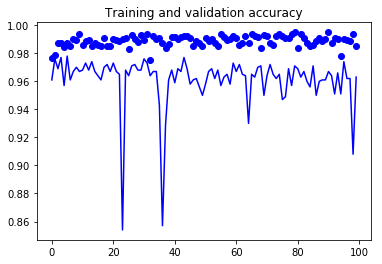

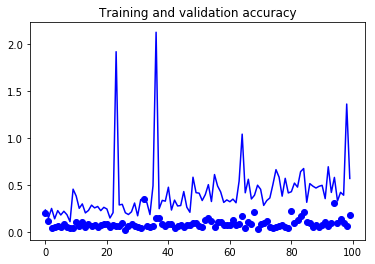

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation accuracy')

plt.show()

### 1.1.13 Smoothing our plots and evaluation

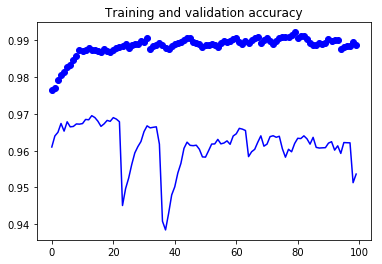

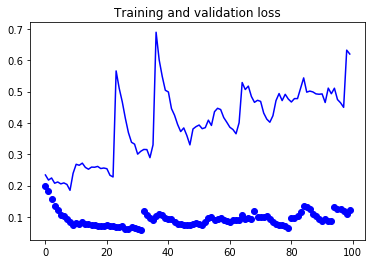

In [23]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo')
plt.plot(epochs, smooth_curve(val_acc), 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo')
plt.plot(epochs, smooth_curve(val_loss), 'b')
plt.title('Training and validation loss')

plt.show()

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=1000)
print('test acc: ', test_acc)

Found 1000 images belonging to 2 classes.
test acc:  0.947999992073
